In [1]:
import os, sys
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import numpy as np
import imageio
import json
import random
import time
import pprint

import matplotlib.pyplot as plt

import run_nerf

from load_llff import load_llff_data
from load_deepvoxels import load_dv_data
from load_blender import load_blender_data


In [2]:
# 사용 가능한 장치 목록 출력
devices = tf.config.list_physical_devices()
for device in devices:
    print(device)

# GPU가 사용 가능한지 확인
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU")
else:
    print("CPU")

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU


In [3]:
basedir = './logs'
expname = 'fern_example'

config = os.path.join(basedir, expname, 'config.txt')
print('Args:')
print(open(config, 'r').read())
parser = run_nerf.config_parser()

args = parser.parse_args('--config {} --ft_path {}'.format(config, os.path.join(basedir, expname, 'model_200000.npy')))
print('loaded args')

images, poses, bds, render_poses, i_test = load_llff_data(args.datadir, args.factor, 
                                                          recenter=True, bd_factor=.75, 
                                                          spherify=args.spherify)
H, W, focal = poses[0,:3,-1].astype(np.float32)

H = int(H)
W = int(W)
hwf = [H, W, focal]

images = images.astype(np.float32)
poses = poses.astype(np.float32)

if args.no_ndc:
    near = tf.reduce_min(bds) * .9
    far = tf.reduce_max(bds) * 1.
else:
    near = 0.
    far = 1.



Args:
datadir = ./data/nerf_llff_data/fern
dataset_type = llff
factor = 4

no_batching = False
i_embed = 0
N_samples = 64
N_importance = 128
use_viewdirs = True
lrate_decay = 250

llffhold = 8

N_rand = 4096
loaded args
Loaded image data (756, 1008, 3, 20) [ 756.         1008.          815.13158322]
Loaded ./data/nerf_llff_data/fern 16.985296178676084 80.00209740336334
recentered (3, 5)
[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00  1.4901161e-09]
 [ 0.0000000e+00  1.0000000e+00 -1.8730975e-09 -9.6857544e-09]
 [-0.0000000e+00  1.8730975e-09  1.0000000e+00  0.0000000e+00]]
Data:
(20, 3, 5) (20, 756, 1008, 3) (20, 2)
HOLDOUT view is 12


MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
Found ckpts ['./logs\\fern_example\\model_200000.npy']
Reloading from ./logs\fern_example\model_200000.npy
Resetting step to 200001
Reloading fine from ./logs\fern_example\model_fine_200000.npy
Render kwargs:
{'N_importance': 128,
 'N_samples': 64,
 'far': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 'near': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'network_fine': <keras.engine.functional.Functional object at 0x00000253D192CF70>,
 'network_fn': <keras.engine.functional.Functional object at 0x00000253D18DFAF0>,
 'network_query_fn': <function create_nerf.<locals>.network_query_fn at 0x00000253CACF3940>,
 'perturb': False,
 'raw_noise_std': 0.0,
 'use_viewdirs': True,
 'white_bkgd': False}


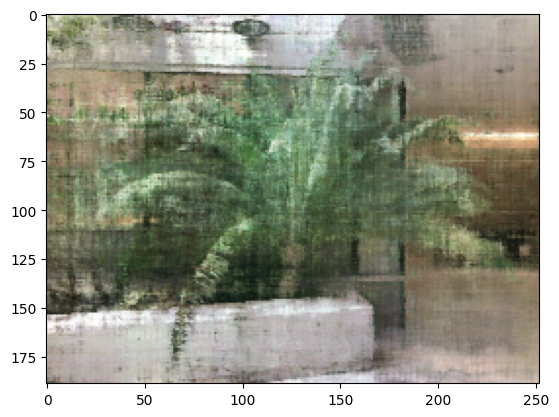

In [4]:
# Create nerf model
_, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(args)

bds_dict = {
    'near' : tf.cast(near, tf.float32),
    'far' : tf.cast(far, tf.float32),
}
render_kwargs_test.update(bds_dict)

print('Render kwargs:')
pprint.pprint(render_kwargs_test)


down = 4
render_kwargs_fast = {k : render_kwargs_test[k] for k in render_kwargs_test}
render_kwargs_fast['N_importance'] = 0

c2w = np.eye(4)[:3,:4].astype(np.float32) # identity pose matrix
test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_fast)
img = np.clip(test[0],0,1)
plt.imshow(img)
plt.show()

In [5]:
down = 4 # trade off resolution+aliasing for render speed to make this video faster
frames = []
for i, c2w in enumerate(render_poses):
    if i%8==0: print(f'{i} of {len(render_poses)}')
    test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w[:3,:4], **render_kwargs_fast)
    frames.append((255*np.clip(test[0],0,1)).astype(np.uint8))
    
print('done, saving')
f = 'logs/fern_example/video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=8)

from IPython.display import Video
Video(f, height=320)

0 of 120
8 of 120
16 of 120
24 of 120
32 of 120
40 of 120
48 of 120
56 of 120
64 of 120
72 of 120
80 of 120
88 of 120
96 of 120
104 of 120
112 of 120
done, saving


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (252, 189) to (256, 192) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets
import matplotlib.pyplot as plt
import numpy as np


def f(x, y, z):
    
    c2w = tf.convert_to_tensor([
        [1,0,0,x],
        [0,1,0,y],
        [0,0,1,z],
        [0,0,0,1],
    ], dtype=tf.float32)
    
    test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_fast)
    img = np.clip(test[0],0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda : widgets.FloatSlider(
    value=0.,
    min=-1.,
    max=1.,
    step=.01,
)

names = ['x', 'y', 'z']
    
interactive_plot = interactive(f, **{n : sldr() for n in names})
interactive_plot